## Importação de Bibliotecas

In [84]:
# Bibliotecas:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools

# Balanceamento
from imblearn.over_sampling import SMOTE, ADASYN

# Redução
from sklearn.decomposition import PCA

# Normalização
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Cluster (agrupamento)
from scipy.spatial.distance import cdist 
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples

# Classificação
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, cross_val_predict

    # Árvore de decisão
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

    # KNN
from sklearn.neighbors import KNeighborsClassifier

    # SVM
from sklearn.svm import SVC

    # Rede neural (MLP)
from sklearn.neural_network import MLPClassifier

# Seleção e pré-processamento de dados:

* **Base de dados**: ["Loan Data Set"](https://www.kaggle.com/datasets/mirzahasnine/loan-data-set?resource=download);
* **Problema a ser investigado**: Aprovação ou não aprovação de empréstimo para pessoas de acordo com seus dados;
* **Número de amostras**: 614;
* **Número de atributos**: 12;
* **Tipos de atributos**: Categóricos e numéricos;
* **Valores ausentes**: Sim.

### Limpeza de dados

* Leitura da base de dados

In [85]:
def ShowInformationDataFrame(df, message=""):
    print(message+"\n")
    # Imprime as 10 primeiras linhas do arquivo
    print("PRIMEIRAS 10 LINHAS\n")
    print(df.head(10))
    print("\n")
    # Imprime informações sobre os dados
    print("INFORMAÇÕES GERAIS DOS DADOS\n")
    print(df.info())
    print("\n")
    # Imprime uma analise descritiva sobre os dados
    print("DESCRIÇÃO DOS DADOS\n")
    print(df.describe())
    print("\n")
    # Imprime a quantidade de valores faltantes por coluna
    print("VALORES FALTANTES\n")
    print(df.isnull().sum())
    print("\n") 

In [86]:
input_file = './0-Datasets/loan_train.csv'
names = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
# columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area', 'Status']
# features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Area']
columns = ['Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History', 'Status']
features = ['Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term','Credit_History']
target = 'Status'
df = pd.read_csv(input_file,        # Nome do arquivo com dados
                names = names,      # Nome das colunas 
                usecols = columns, # Define as colunas que serão  utilizadas
                na_values='')       # Define que ? será considerado valores ausentes

ShowInformationDataFrame(df, "DataFrame")

DataFrame

PRIMEIRAS 10 LINHAS

  Married Dependents     Education Self_Employed  Applicant_Income  \
0      No          0  Not Graduate            No            604500   
1      No          0      Graduate            No            584900   
2     Yes          1      Graduate            No            458300   
3     Yes          0      Graduate           Yes            300000   
4     Yes          0  Not Graduate            No            258300   
5      No          0      Graduate            No            600000   
6     Yes          2      Graduate           Yes            541700   
7     Yes          0  Not Graduate            No            233300   
8     Yes         3+      Graduate            No            303600   
9     Yes          2      Graduate            No            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History Status  
0                 0.0     11500000  360.0             0.0      N  
1                 0.0     15000000  360.0             1.0      

* Tratamento dos valores faltantes
  * método de DELETAR os objetos que possuem valores faltantes

In [87]:
def UpdateMissingValues(df, column, method="mode", number=0):
    if method == 'number':
        # Substituindo valores ausentes por um número
        df[column].fillna(number, inplace=True)
    elif method == 'median':
        # Substituindo valores ausentes pela mediana 
        median = df[column].median()
        df[column].fillna(median, inplace=True)
    elif method == 'mean':
        # Substituindo valores ausentes pela média
        mean = df[column].mean()
        df[column].fillna(mean, inplace=True)
    elif method == 'mode':
        # Substituindo valores ausentes pela moda
        mode = df[column].mode()[0]
        df[column].fillna(mode, inplace=True)
    elif method == 'delete':
        df.dropna(axis=0, how='any', subset=column, inplace=True)

columns_missing_value = df.columns[df.isnull().any()]
print(columns_missing_value)
method = 'delete' # number or median or mean or mode
    
for c in columns_missing_value:
    UpdateMissingValues(df, c, method)
    
ShowInformationDataFrame(df,"Dataframe UpdateMissingValues")

Index(['Married', 'Dependents', 'Self_Employed', 'Term', 'Credit_History'], dtype='object')
Dataframe UpdateMissingValues

PRIMEIRAS 10 LINHAS

  Married Dependents     Education Self_Employed  Applicant_Income  \
0      No          0  Not Graduate            No            604500   
1      No          0      Graduate            No            584900   
2     Yes          1      Graduate            No            458300   
3     Yes          0      Graduate           Yes            300000   
4     Yes          0  Not Graduate            No            258300   
5      No          0      Graduate            No            600000   
6     Yes          2      Graduate           Yes            541700   
7     Yes          0  Not Graduate            No            233300   
8     Yes         3+      Graduate            No            303600   
9     Yes          2      Graduate            No            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History Status  
0                 

* Conversão dos atributos categóricos para numéricos

In [88]:
# Converte os atributos categóricos para numéricos
    # get all categorical columns
cat_columns = df.select_dtypes(['object']).columns

    # convert all categorical columns to numeric
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

ShowInformationDataFrame(df,"Dataframe numérico")

Dataframe numérico

PRIMEIRAS 10 LINHAS

   Married  Dependents  Education  Self_Employed  Applicant_Income  \
0        0           0          0              0            604500   
1        0           0          1              0            584900   
2        1           1          1              0            458300   
3        1           0          1              1            300000   
4        1           0          0              0            258300   
5        0           0          1              0            600000   
6        1           2          1              1            541700   
7        1           0          0              0            233300   
8        1           3          1              0            303600   
9        1           2          1              0            400600   

   Coapplicant_Income  Loan_Amount   Term  Credit_History  Status  
0                 0.0     11500000  360.0             0.0       0  
1                 0.0     15000000  360.0           

### Balanceamento de dados

A base se apresentou desbalanceada, dessa forma, foi necessário utilizar uma técnica de balanceamento.

* Técnicas de Oversample:
  * SMOTE (utilizada)
  * ADASYN

Base default
 1    348
0    163
Name: Status, dtype: int64
Base balanceada
 0    348
1    348
Name: Status, dtype: int64


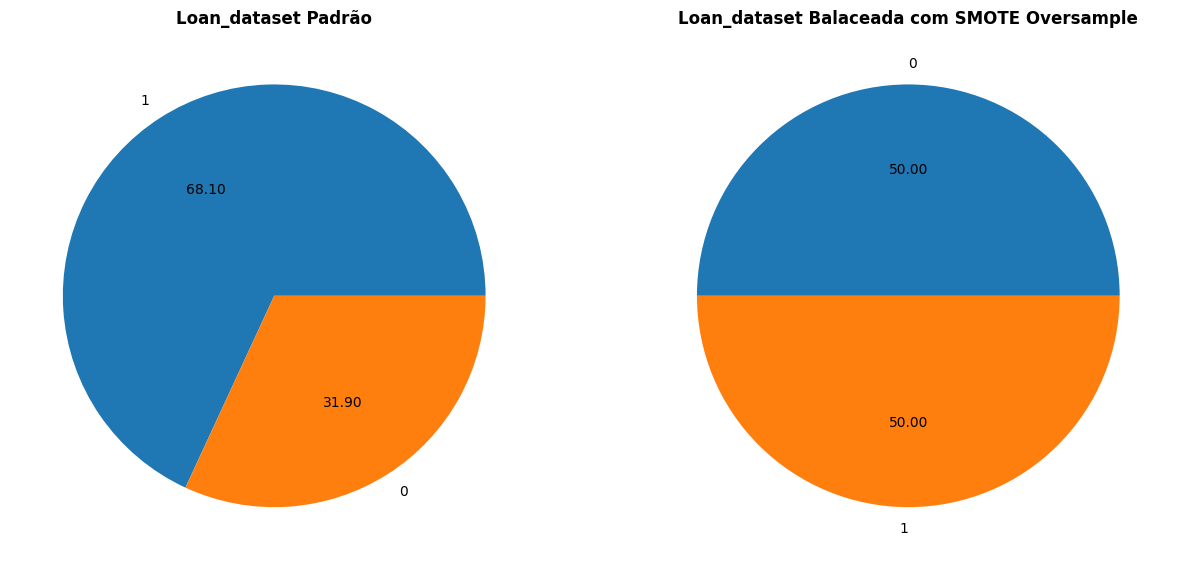

In [89]:
x = df.drop(['Status'], axis=1)
y = df['Status']

# Synthetic Minority Oversampling Technique (SMOTE)
x_os, y_os = SMOTE().fit_resample(x, y)
# Adaptive Synthetic (ADASYN) sampling method
# x_os, y_os = ADASYN().fit_resample(x, y)

print('Base default\n',y.value_counts())
print('Base balanceada\n',y_os.value_counts())

fig, ax = plt.subplots(1, 2, figsize=(15, 10))

y.value_counts().plot.pie(ax=ax[0], autopct='%.2f')
y_os.value_counts().plot.pie(ax=ax[1], autopct='%.2f')

plt.subplots_adjust(hspace = 1)

for n in np.arange(0,2):
    ax[n].set_ylabel('')
    
ax[0].set_title('Loan_dataset Padrão', fontweight='bold')
ax[1].set_title('Loan_dataset Balaceada com SMOTE Oversample', fontweight='bold')

plt.show()

---
# Normalização e redução de dados

### Normalização de dados
* Max-Min
* Z-Score

In [90]:
# Z-score normalization
x_zcore = StandardScaler().fit_transform(x_os)
normalized_zscore_Df = pd.DataFrame(data = x_zcore, columns = features)
normalized_zscore_Df = pd.concat([normalized_zscore_Df, y_os], axis = 1)
ShowInformationDataFrame(normalized_zscore_Df,"Dataframe Z-Score Normalized")

# Mix-Max normalization
x_minmax = MinMaxScaler().fit_transform(x_os)
normalized_minmax_Df = pd.DataFrame(data = x_minmax, columns = features)
normalized_minmax_Df = pd.concat([normalized_minmax_Df, y_os], axis = 1)
ShowInformationDataFrame(normalized_minmax_Df,"Dataframe Min-Max Normalized")

Dataframe Z-Score Normalized

PRIMEIRAS 10 LINHAS

    Married  Dependents  Education  Self_Employed  Applicant_Income  \
0 -1.155669   -0.735944  -1.649826      -0.362915          0.116793   
1 -1.155669   -0.735944   0.606125      -0.362915          0.080954   
2  0.865300    0.300933   0.606125      -0.362915         -0.150535   
3  0.865300   -0.735944   0.606125       2.755466         -0.439988   
4  0.865300   -0.735944  -1.649826      -0.362915         -0.516237   
5 -1.155669   -0.735944   0.606125      -0.362915          0.108565   
6  0.865300    1.337809   0.606125       2.755466          0.001963   
7  0.865300   -0.735944  -1.649826      -0.362915         -0.561949   
8  0.865300    2.374686   0.606125      -0.362915         -0.433405   
9  0.865300    1.337809   0.606125      -0.362915         -0.256040   

   Coapplicant_Income  Loan_Amount      Term  Credit_History  Status  
0           -0.645977    -0.316065  0.295947       -2.008009       0  
1           -0.645977    

### Redução de dados (PCA)

Explained variance per component:
[0.3221109419642526, 0.23751788829466774, 0.17115536737208095, 0.12304678821818747, 0.09535131989314173, 0.02424308056669157, 0.01788465062955865, 0.005873673535913128, 0.0028162895255060944]



Dataframe PCA

PRIMEIRAS 10 LINHAS

   principal component 1  principal component 2  Status
0               0.873083               0.746475       0
1               0.513763              -0.462578       1
2              -0.501647              -0.207980       0
3              -0.428758              -0.263814       1
4              -0.191943               0.664919       1
5               0.514363              -0.462033       1
6              -0.657241              -0.179158       1
7              -0.189698               0.666772       1
8              -0.562279               0.174588       0
9              -0.610234              -0.160869       1


INFORMAÇÕES GERAIS DOS DADOS

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Data columns (t

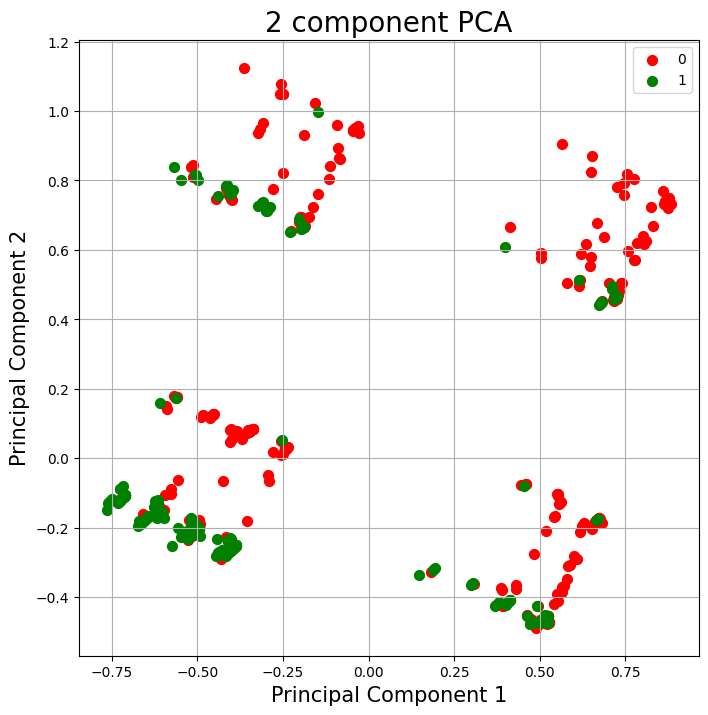

In [91]:
def VisualizePcaProjection(finalDf, targetColumn):
    fig = plt.figure(figsize = (8,8))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)

    ax.set_title('2 component PCA', fontsize = 20)
    targets = [ 0, 1 ]
    colors = ['r', 'g']
    for target, color in zip(targets,colors):
        indicesToKeep = finalDf[targetColumn] == target
        ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'],
                   finalDf.loc[indicesToKeep, 'principal component 2'],
                   c = color, s = 50)
    ax.legend(targets)
    ax.grid()
    plt.show()

# PCA projection
pca = PCA()
# utilizando a normalização Z-Score    
# principalComponents = pca.fit_transform(x_zcore)
# utilizando a normalização Max-Min  
principalComponents = pca.fit_transform(x_minmax)
print("Explained variance per component:")
print(pca.explained_variance_ratio_.tolist())
print("\n\n")

principalDf = pd.DataFrame(data = principalComponents[:,0:2], 
                            columns = ['principal component 1', 
                                        'principal component 2'])
finalDf = pd.concat([principalDf, y_os], axis = 1)    
ShowInformationDataFrame(finalDf,"Dataframe PCA")

VisualizePcaProjection(finalDf, target)

---
# Análise descritiva de dados
* Distribuição de frequência
* Visualização de dados (Histograma, Gráfico de setores, dispersão, etc)
* Medidas de resumo
  * Medidas de tendência central
  * Medidas de dispersão
  * Medidas de posição relativa
  * Medidas de associação

---
# Análise de grupos

In [92]:
def plot_samples(projected, labels, title):    
    fig = plt.figure()
    u_labels = np.unique(labels)
    for i in u_labels:
        plt.scatter(projected[labels == i , 0] , projected[labels == i , 1] , label = i,
                    edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('tab10', 10))
    plt.xlabel('component 1')
    plt.ylabel('component 2')
    plt.legend()
    plt.title(title)
    plt.show()

### K-means
* Variar número de grupos (parâmetro k)

##### K-means Sklearn

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


406.1150818623209
For n_clusters = 2, silhouette score is 0.3387278667685998)
For n_clusters = 2, homogeinity score is 0.037354277842357834)


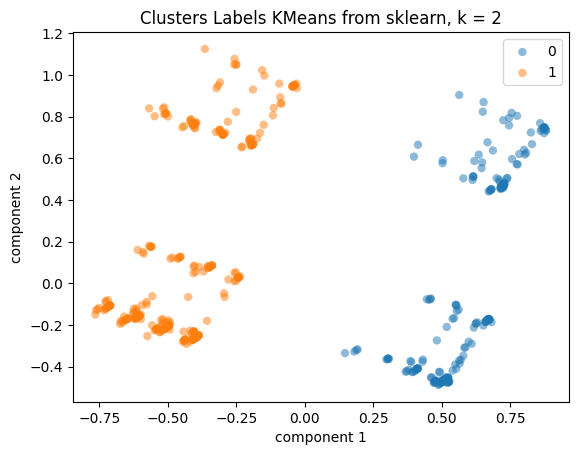

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


317.3156339605547
For n_clusters = 3, silhouette score is 0.3715712920350071)
For n_clusters = 3, homogeinity score is 0.056401612965727446)


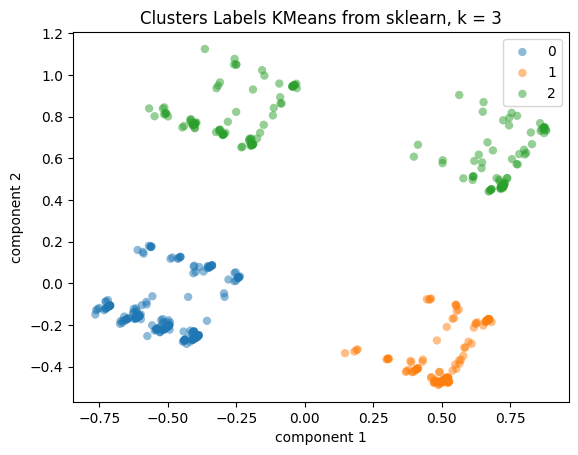

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


267.3853925385235
For n_clusters = 4, silhouette score is 0.4171975249231491)
For n_clusters = 4, homogeinity score is 0.06336776039145933)


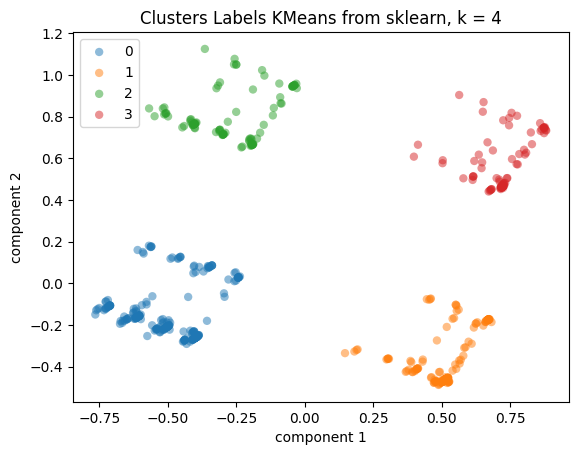

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


221.87485586900516
For n_clusters = 5, silhouette score is 0.4456941452236777)
For n_clusters = 5, homogeinity score is 0.19308769116174163)


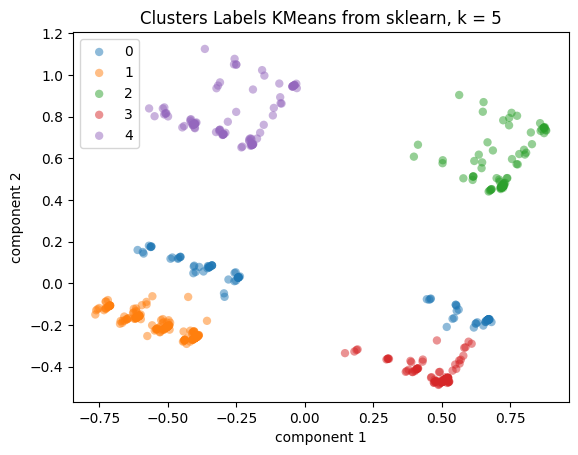

In [93]:
#Applying sklearn kmeans function
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k).fit(principalComponents)
    print(kmeans.inertia_)
    centers = kmeans.cluster_centers_
    score = silhouette_score(principalComponents, kmeans.labels_)    
    print("For n_clusters = {}, silhouette score is {})".format(k, score))
    homogeneity = homogeneity_score(y_os.to_numpy(), kmeans.labels_)
    print("For n_clusters = {}, homogeinity score is {})".format(k, homogeneity))

    #Visualize the results sklearn
    plot_samples(principalComponents, kmeans.labels_, f'Clusters Labels KMeans from sklearn, k = {k}')

#### K-means implementado

For n_clusters = 2, silhouette score is 0.3387278667685998)
For n_clusters = 2, homogeinity score is 0.037354277842357834)


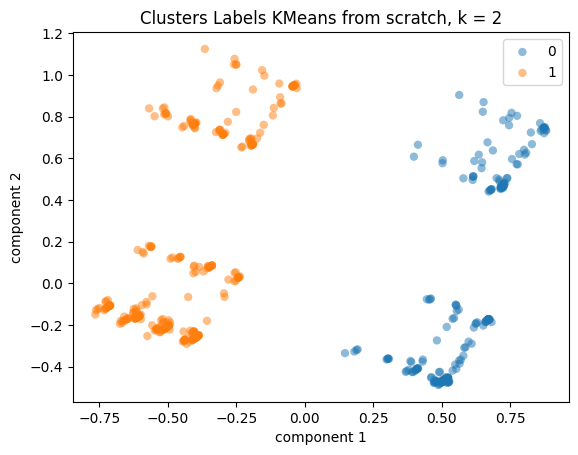

For n_clusters = 3, silhouette score is 0.34005184732627125)
For n_clusters = 3, homogeinity score is 0.04662658988222209)


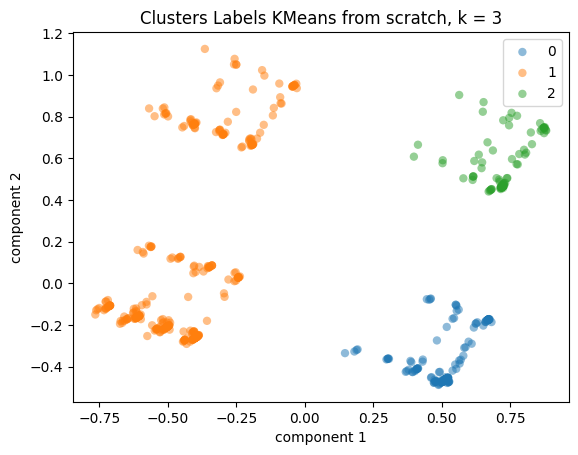

For n_clusters = 4, silhouette score is 0.2914316287230082)
For n_clusters = 4, homogeinity score is 0.04200509471464206)


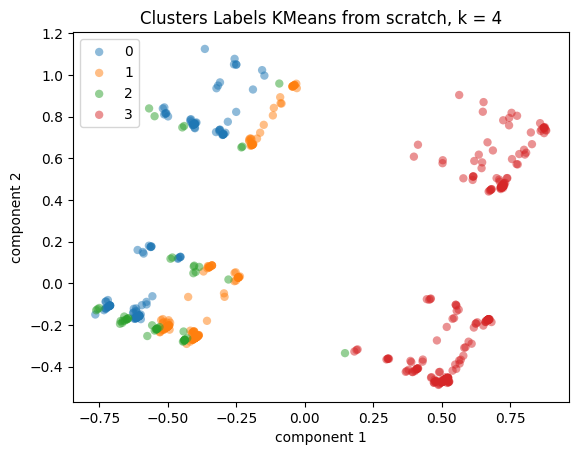

For n_clusters = 5, silhouette score is 0.2599408740560217)
For n_clusters = 5, homogeinity score is 0.1512574915793796)


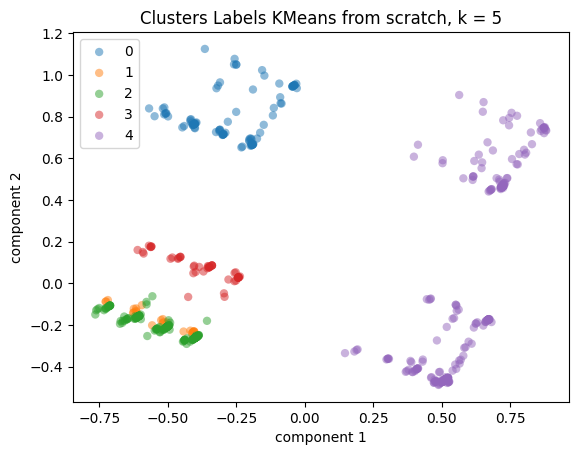

For n_clusters = 6, silhouette score is 0.3215041307965215)
For n_clusters = 6, homogeinity score is 0.10858257522083084)


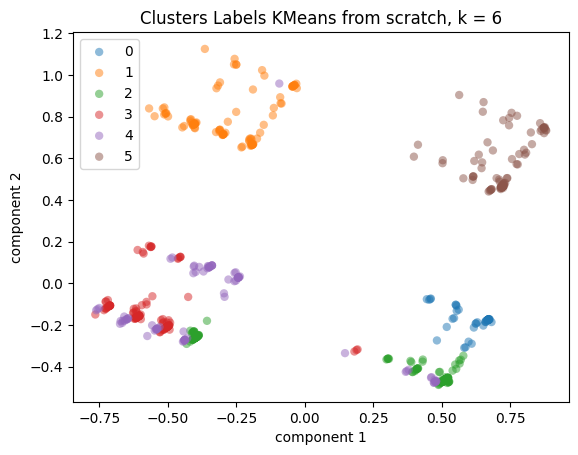

For n_clusters = 7, silhouette score is 0.4211288069367399)
For n_clusters = 7, homogeinity score is 0.10290679178329282)


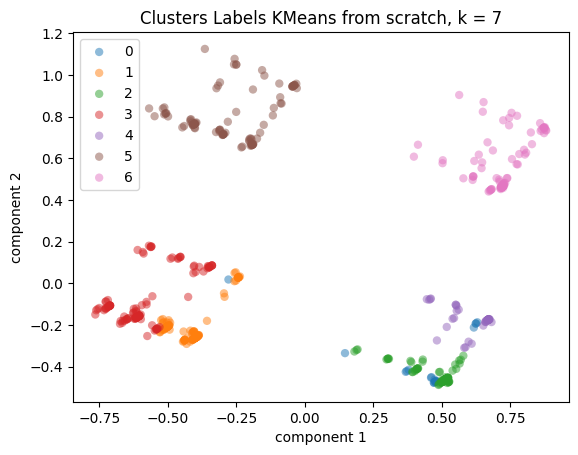

In [94]:
#Defining our kmeans function from scratch
def KMeans_scratch(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    #Randomly choosing Centroids 
    centroids = x[idx, :] #Step 1
     
    #finding the distance between centroids and all the data points
    distance_type = ('euclidean', 'cityblock', 'minkowski', 'mahalanobis')
    dtype = 2
    distances = cdist(x, centroids ,distance_type[dtype]) #Step 2
    # Euclidean, Cityblock, Minkowski, Mahalanobis
     
    #Centroid with the minimum Distance
    points = np.array([np.argmin(i) for i in distances]) #Step 3
     
    #Repeating the above steps for a defined number of iterations
    #Step 4
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            #Updating Centroids by taking mean of Cluster it belongs to
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) #Updated Centroids 
         
        distances = cdist(x, centroids ,distance_type[dtype])
        points = np.array([np.argmin(i) for i in distances])
         
    return points

for k in range(2, 8):
    #Applying our kmeans function from scratch
    labels = KMeans_scratch(principalComponents,k,25)

    score = silhouette_score(principalComponents, labels)    
    print("For n_clusters = {}, silhouette score is {})".format(k, score))
    homogeneity = homogeneity_score(y_os.to_numpy(), labels)
    print("For n_clusters = {}, homogeinity score is {})".format(k, homogeneity))

    #Visualize the results 
    plot_samples(principalComponents, labels, f'Clusters Labels KMeans from scratch, k = {k}')

### GMM

[0.57183908 0.42816092]
[[-4.33343733e-01  7.14640053e-02  1.67553000e-02 -2.05213896e-02
  -4.69070083e-02 -7.61982011e-04 -7.30639946e-04 -1.92382754e-04
   5.57600398e-06]
 [ 5.78761093e-01 -9.54452152e-02 -2.23778839e-02  2.74077619e-02
   6.26476152e-02  1.01768067e-03  9.75821136e-04  2.56940725e-04
  -7.44714625e-06]]
For k = 2
Silhouette score is 0.3387278667685998
Homogeinity score is 0.037354277842357834


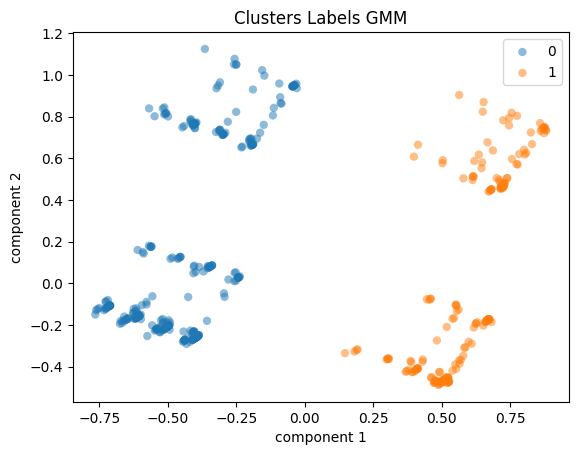

[0.43390942 0.23744701 0.32864357]
[[-4.70662552e-01 -1.43681603e-02 -1.51062735e-01 -1.23105640e-02
  -3.28234037e-02 -1.36201504e-03 -1.00422807e-02  1.18105762e-03
  -4.49863748e-03]
 [ 1.00773172e-01  2.52659907e-01  5.79519204e-01 -2.41793116e-02
  -2.53464571e-02  1.53720682e-03  1.04657371e-02 -4.49647618e-03
   8.21947933e-03]
 [ 5.48608413e-01 -1.63578006e-01 -2.19257476e-01  3.37233891e-02
   6.16498434e-02  6.87632483e-04  5.69730368e-03  1.68937675e-03
   9.44413337e-07]]
For k = 3
Silhouette score is 0.32466609551102893
Homogeinity score is 0.2551576926172662


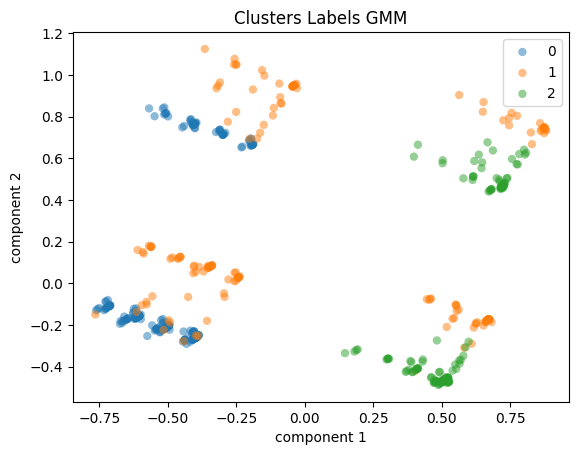

[0.12931034 0.43247126 0.29885057 0.13936782]
[[ 7.21493518e-01  5.68681474e-01 -1.92050979e-01  7.31233135e-02
   3.01745237e-02 -1.22804673e-02  5.99810372e-03 -7.12310219e-03
   2.64380408e-03]
 [-4.85271111e-01 -1.63178606e-01  7.00538609e-02 -7.67151910e-03
  -4.19021512e-02 -1.96997687e-03 -1.11527018e-03 -2.39101857e-03
   7.63179568e-04]
 [ 5.17001871e-01 -3.82807725e-01  5.10383594e-02  7.62699437e-03
   7.66984720e-02  6.77168701e-03 -1.19728191e-03  3.45022852e-03
  -1.15462316e-03]
 [-2.72208259e-01  7.99581800e-01 -1.48635080e-01 -6.03957299e-02
  -6.24375444e-02  2.98653812e-03  4.62903371e-04  6.63018819e-03
  -2.34533815e-03]]
For k = 4
Silhouette score is 0.4171975249231491
Homogeinity score is 0.06336776039145933


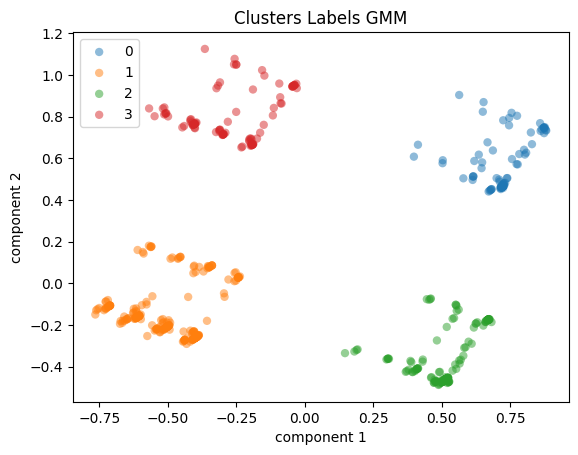

[0.43247126 0.08623681 0.21261376 0.13936782 0.12931034]
[[-4.85271111e-01 -1.63178606e-01  7.00538609e-02 -7.67151910e-03
  -4.19021512e-02 -1.96997687e-03 -1.11527018e-03 -2.39101857e-03
   7.63179568e-04]
 [ 6.01049707e-01 -2.16802187e-01  5.90152481e-01 -2.06639708e-02
   6.64539884e-02  8.21316527e-03 -1.02478932e-02 -4.98476220e-03
  -6.83536455e-03]
 [ 4.82911805e-01 -4.50140092e-01 -1.67628020e-01  1.91018986e-02
   8.08536667e-02  6.18701890e-03  2.47367443e-03  6.87148724e-03
   1.14950338e-03]
 [-2.72208259e-01  7.99581800e-01 -1.48635080e-01 -6.03957299e-02
  -6.24375444e-02  2.98653812e-03  4.62903371e-04  6.63018819e-03
  -2.34533815e-03]
 [ 7.21493518e-01  5.68681474e-01 -1.92050979e-01  7.31233135e-02
   3.01745237e-02 -1.22804673e-02  5.99810372e-03 -7.12310219e-03
   2.64380408e-03]]
For k = 5
Silhouette score is 0.3953649870591197
Homogeinity score is 0.12316453721962069


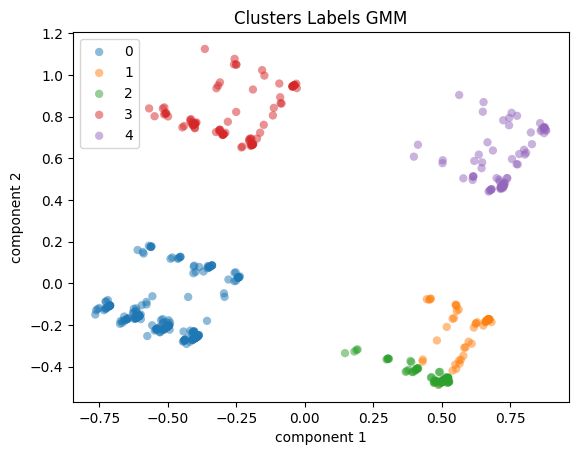

[0.31960082 0.28001031 0.06321383 0.13936782 0.14815061 0.04965661]
[[-5.02104604e-01 -2.11244540e-01 -8.75090112e-02 -3.07243708e-02
  -4.74255670e-02  6.68384713e-03 -2.73110512e-02  7.86667750e-04
  -7.22463741e-03]
 [ 5.31945526e-01 -2.27194728e-01 -2.43709028e-01  3.22980444e-02
   6.40668324e-02  3.16396045e-03  2.00559984e-03  1.93809811e-03
   2.05107753e-03]
 [-3.86263057e-01  8.78374386e-02  8.64439720e-01  4.05208621e-02
  -1.72699907e-02  1.95273992e-03 -3.96655964e-03 -3.72276885e-03
   1.29497137e-02]
 [-2.72208259e-01  7.99581800e-01 -1.48635080e-01 -6.03957299e-02
  -6.24375444e-02  2.98653812e-03  4.62903371e-04  6.63018819e-03
  -2.34533815e-03]
 [ 6.67244299e-01  1.53566387e-01  3.95946416e-01  1.81649416e-02
   5.99652405e-02 -3.03886994e-03 -9.70499867e-04 -2.92051084e-03
  -3.89813728e-03]
 [-5.02966243e-01 -1.73364033e-01  7.28943788e-02  7.93518374e-02
  -3.77094568e-02 -6.26615724e-02  1.71116244e-01 -2.11479580e-02
   3.66608209e-02]]
For k = 6
Silhouette scor

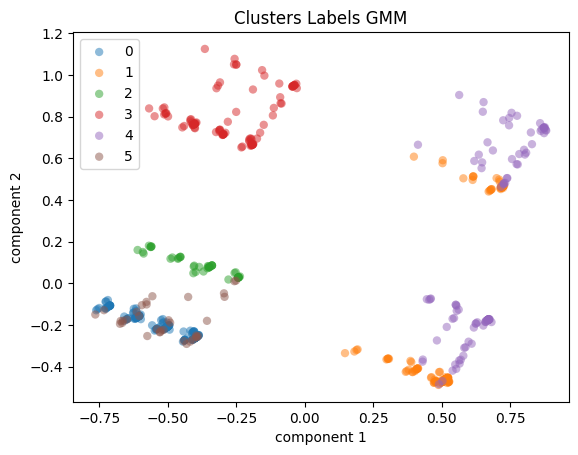

[0.29885057 0.04886456 0.06321383 0.12931034 0.09050326 0.31960165
 0.04965578]
[[ 5.17001871e-01 -3.82807725e-01  5.10383594e-02  7.62699437e-03
   7.66984720e-02  6.77168701e-03 -1.19728191e-03  3.45022852e-03
  -1.15462316e-03]
 [-1.48435660e-01  9.19515123e-01  3.09300613e-01 -1.37045952e-01
  -2.13726331e-01  1.95617542e-02  2.22765295e-02  1.26534950e-02
  -2.18797433e-03]
 [-3.86263057e-01  8.78374386e-02  8.64439720e-01  4.05208633e-02
  -1.72699907e-02  1.95274024e-03 -3.96656002e-03 -3.72276933e-03
   1.29497138e-02]
 [ 7.21493518e-01  5.68681474e-01 -1.92050979e-01  7.31233135e-02
   3.01745237e-02 -1.22804673e-02  5.99810372e-03 -7.12310219e-03
   2.64380408e-03]
 [-3.39035618e-01  7.34827344e-01 -3.95883930e-01 -1.90107065e-02
   1.92463670e-02 -5.96276020e-03 -1.13147197e-02  3.37808158e-03
  -2.43030209e-03]
 [-5.02104835e-01 -2.11244551e-01 -8.75089500e-02 -3.07225151e-02
  -4.74255935e-02  6.68357579e-03 -2.73103098e-02  7.86524863e-04
  -7.22467950e-03]
 [-5.02964769e

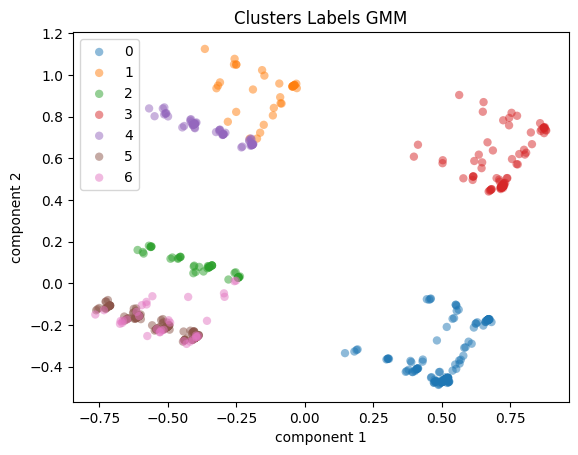

In [95]:
for k in range(2, 8):
    #Applying sklearn GMM function
    gm  = GaussianMixture(n_components=k).fit(principalComponents)
    print(gm.weights_)
    print(gm.means_)
    gm_predicts = gm.predict(principalComponents)
    silhouette_gm_score = silhouette_score(principalComponents, gm_predicts)
    homogeneity_gm_score = homogeneity_score(y_os.to_numpy(), gm_predicts)
    print("For k =", k)
    print("Silhouette score is {}".format(silhouette_gm_score))
    homogeneity = homogeneity_score(y_os.to_numpy(), kmeans.labels_)
    print("Homogeinity score is {}".format(homogeneity_gm_score))
    #Visualize the results sklearn
    plot_samples(principalComponents, gm_predicts, 'Clusters Labels GMM')

---
# Classificação
* Divisão da base:
  * Holdout (Treinamento 70% e Teste 30%)
  * Cross-Validation (k=10)
* Métricas:
  * Matrix de confusão
  * Acurácia
  * F1 Score

In [96]:
x_use = x_zcore # ou x_minmax ou x_zscore
y_use = y_os

# Separação de conjunto de treinamento (70%) e teste (30%)
x_train, x_test, y_train, y_test = train_test_split(x_use, y_use, test_size=0.3, random_state=0)
print(x_train.shape)
print(x_test.shape)

acuracia_holdout = dict()
f1_holdout = dict()
acuracia_crossval = dict()
f1_crossval = dict()

(487, 9)
(209, 9)


### Árvore de Decisão (Decision Tree)

* Holdout

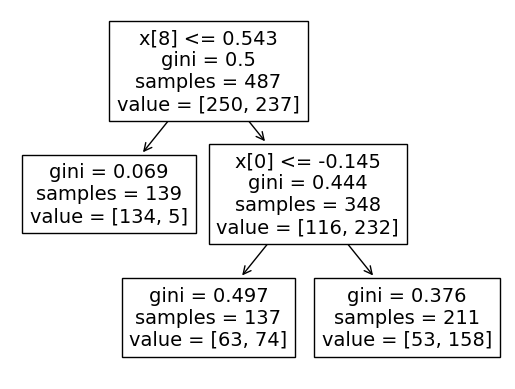

[0 1 0 1 1 1 1 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 1 1 1 1 1
 0 1 0 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 1 1
 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0
 1 0 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1]
accuracy_score = 0.7799043062200957
f1_score = 0.8257575757575758


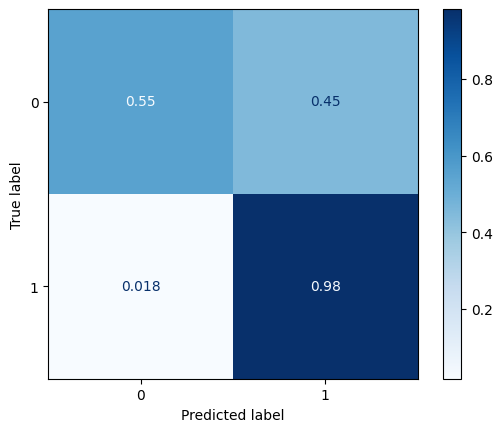

In [97]:
# Construindo a Árvore de decisão
clf = DecisionTreeClassifier(max_leaf_nodes=3)
clf.fit(x_train, y_train)
tree.plot_tree(clf)
plt.show()

predictions = clf.predict(x_test)
print(predictions)

# Métricas
accuracy = accuracy_score(y_test, predictions)
f1_score = f1_score(y_test, predictions)
confusion_matrix = confusion_matrix(y_test, predictions, normalize='true')
print('accuracy_score =', accuracy)
print('f1_score =', f1_score)
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['DecisionTree'] = accuracy
f1_holdout['DecisionTree'] = f1_score

* Cross-Validation

[0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 1 1 1
 1 1 1 1 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1
 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 

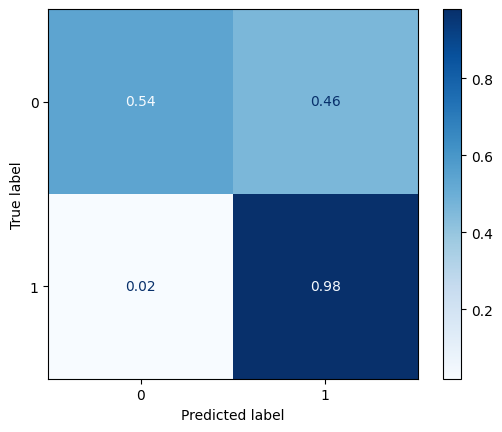

In [98]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Validação-cruzada
clf = DecisionTreeClassifier(max_leaf_nodes=3)
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)
# tree.plot_tree(clf)
# plt.show()

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
print(predictions)

# Métricas
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
print('accuracy_score =', accuracy)
print('f1_score =', f1_score)
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['DecisionTree'] = accuracy
f1_crossval['DecisionTree'] = f1_score

### KNN (K-Mearest Neighbors)
* Encontrar o parâmetro k com melhor resultado

* Holdout

Best K: 46
Best Accuracy: 0.7799043062200957
Acurracy K-NN: 77.99%
F1 Score K-NN: 81.15%


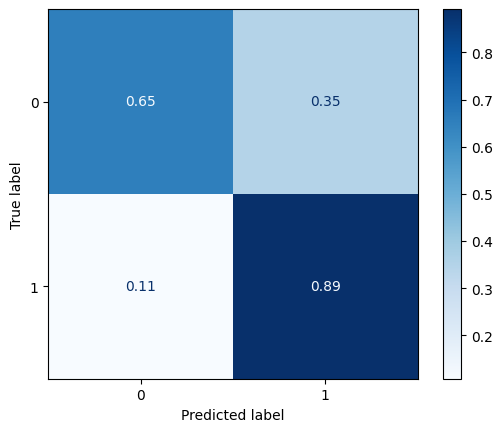

In [99]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

best_k = 0
best_accuracy = 0
for k in range(1, 100):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    y_hat_test = knn.predict(x_test)
    accuracy = accuracy_score(y_test, y_hat_test)
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f'Best K: {best_k}\nBest Accuracy: {best_accuracy}')

# TESTS USING knn classifier from sk-learn
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)
y_hat_test = knn.predict(x_test)

# Get test accuracy and F1 score
accuracy = accuracy_score(y_test, y_hat_test)
f1_score = f1_score(y_test, y_hat_test)
print("Acurracy K-NN: {:.2f}%".format(accuracy * 100))
print("F1 Score K-NN: {:.2f}%".format(f1_score * 100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_test, y_hat_test, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['KNN'] = accuracy
f1_holdout['KNN'] = f1_score

* Cross-Validation

Best K: 1
Best Accuracy: 0.7745755693581781
[0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 0
 0 1 0 1 1 0 1 1 0 1 1 0 1 1 1 1 0 0 0 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 1 1 1 0
 1 1 0 1 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 1 0 1 0 1 1 1 1 1
 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 0
 0 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 1 0 1 1 1 1
 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1 1 0 1 0 0
 1 0 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 0
 1 0 1 1 1 0 0 1 0 0 0 1 0 1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 0 0 0 1
 1 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 1 1 0 0 0 0 0 0 1 1
 0 0 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1
 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 0
 0 0 1 1 0 1 0 1 1 0 1 0 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0

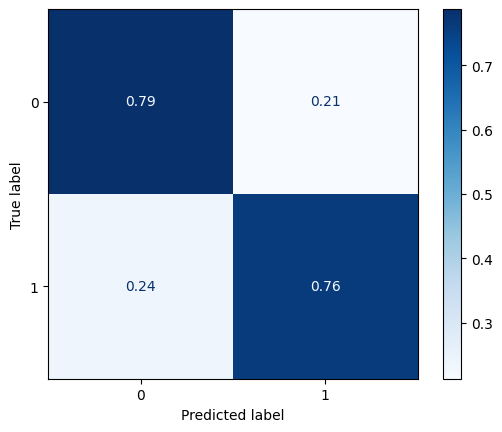

In [100]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


best_k = 0
best_accuracy = 0
for k in range(1, 50):
    clf = KNeighborsClassifier(n_neighbors=k)
    result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)
    accuracy = result['test_accuracy'].mean()
    if accuracy > best_accuracy:
        best_k = k
        best_accuracy = accuracy

print(f'Best K: {best_k}\nBest Accuracy: {best_accuracy}')

# Validação-cruzada
clf = KNeighborsClassifier(n_neighbors=best_k)
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
print(predictions)

# Métricas
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
print('accuracy_score =', accuracy)
print('f1_score =', f1_score)
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['KNN'] = accuracy
f1_crossval['KNN'] = f1_score

### SVM (Support Vectors Machine)

* Holdout

[[-1.15566884 -0.73594414  0.6061246  ...  3.94228088  0.29594703
   0.5291868 ]
 [ 0.86529979 -0.73594414 -1.64982579 ... -0.88128019 -0.19388266
   0.10653524]
 [-1.15566884 -0.73594414  0.6061246  ...  0.5031284   0.29594703
   0.5569231 ]
 ...
 [-1.15566884 -0.73594414  0.6061246  ...  0.16374841  0.29594703
   0.5569231 ]
 [-1.15566884 -0.73594414 -1.64982579 ...  0.14034289  0.29594703
   0.5569231 ]
 [-1.15566884 -0.73594414  0.6061246  ... -0.49160607  0.29594703
   0.5569231 ]]
[  1   8  26  28  29  30  33  42  45  47  51  55  60  63  66  79  81  86
  87  93  98  99 100 102 103 107 111 113 119 122 130 131 133 134 135 140
 141 147 149 156 161 162 165 169 174 177 178 183 185 187 194 202 206 207
 209 212 217 218 219 225 228 229 230 231 233 238 240 244 246 247 250 255
 258 260 262 263 264 266 268 269 270 275 278 279 282 291 296 298 302 303
 304 306 309 312 314 315 318 319 321 327 328 333 341 344 345 348 353 366
 370 379 385 386 388 389 392 395 403 407 411 412 414 417 422 425 435 4

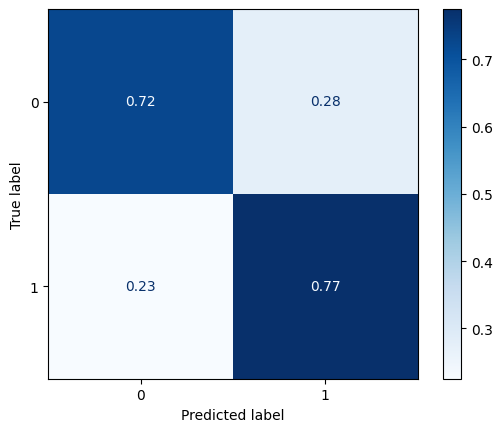

In [101]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

 # TESTS USING SVM classifier from sk-learn    
svm = SVC(kernel='linear') # poly, rbf, linear
# training using train dataset
svm.fit(x_train, y_train)
# get support vectors
print(svm.support_vectors_)
# get indices of support vectors
print(svm.support_)
# get number of support vectors for each class
print("Qtd Support vectors: ")
print(svm.n_support_)
# predict using test dataset
y_hat_test = svm.predict(x_test)

# Get test accuracy score
accuracy = accuracy_score(y_test, y_hat_test)
f1_score = f1_score(y_test, y_hat_test)
print("Acurracy SVM from sk-learn: {:.2f}%".format(accuracy*100))
print("F1 Score SVM from sk-learn: {:.2f}%".format(f1_score*100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_test, y_hat_test, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['SVM'] = accuracy
f1_holdout['SVM'] = f1_score

* Cross-Validation

[0 1 1 1 0 1 1 1 0 1 0 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1
 0 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 0 1 0 1 0 1
 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0 1 1 1 1 1 1 0 0 1 0 1 1 0 0
 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0
 1 1 1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 0 1 0 0 0 0 0 0
 1 1 1 0 0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0
 0 0 1 0 1 0 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1
 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1
 1 0 1 0 1 1 0 1 0 1 1 1 

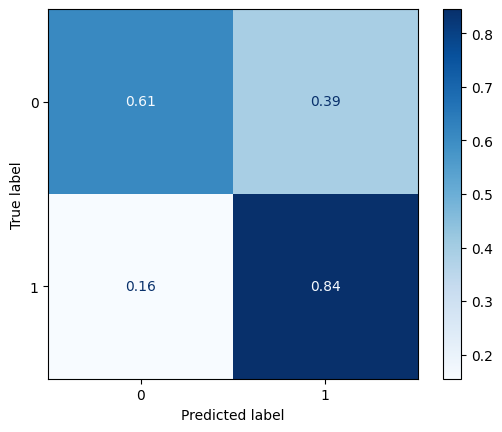

In [102]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Validação-cruzada
clf = SVC(kernel='linear') # poly, rbf, linear
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)
# tree.plot_tree(clf)
# plt.show()

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
print(predictions)

# Métricas
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
print('accuracy_score =', accuracy)
print('f1_score =', f1_score)
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['SVM'] = accuracy
f1_crossval['SVM'] = f1_score

### Rede Neural MLP (Multilayer Perceptron)
* Arquitetura da rede:
  * Número de neurônios
  * Camadas escondidas
  * Tipo de função de ativação

* Holdout

[0 1 1 0 1 1 1 1 0 1 1 1 0 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 1 0 1 0 1 0 1 0 0 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0
 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1
 1 1 1 1 0 1 1 0 1 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 1 0 0 1 0 1 1 1 0 1 1 1
 0 1 0 0 1 1 1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 1 0]
Acurracy MLP from sk-learn: 78.47%
F1 Score MLP from sk-learn: 79.45%


c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


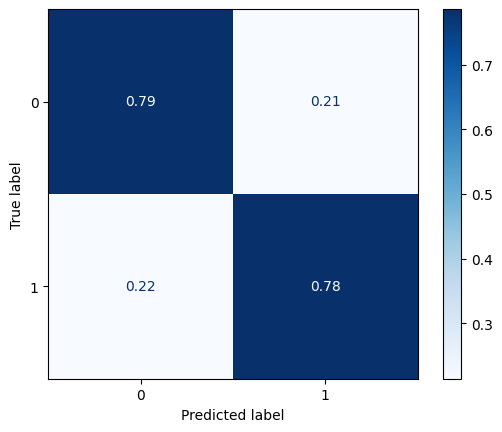

In [106]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

mlp = MLPClassifier(hidden_layer_sizes=(11,11,11),
                    activation='relu')
mlp.fit(x_train, y_train)
predictions = mlp.predict(x_test)
print(predictions)

# Get test accuracy score
accuracy = accuracy_score(y_test, predictions)
f1_score = f1_score(y_test, predictions)
print("Acurracy MLP from sk-learn: {:.2f}%".format(accuracy*100))
print("F1 Score MLP from sk-learn: {:.2f}%".format(f1_score*100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_test, predictions, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_holdout['MLP'] = accuracy
f1_holdout['MLP'] = f1_score

* Cross-Validation

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the opti

[0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 1 0 1 1 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0
 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1
 0 1 0 0 1 1 1 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1
 0 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1
 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 0 1 0 0
 1 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 0
 1 1 1 1 1 0 0 1 0 1 1 0 0 1 1 0 1 0 1 1 1 1 0 1 1 1 1 0 1 0 1 1 0 0 0 0 0
 1 1 1 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 1 1 0 0 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0
 1 0 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 0 1 0 0 0
 1 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 1 1 1 1 0 1 0 0 1 0 1 0 1 1 0 1 1 0 1 1
 1 1 1 0 1 1 0 1 0 1 1 1 

c:\Users\lucas\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


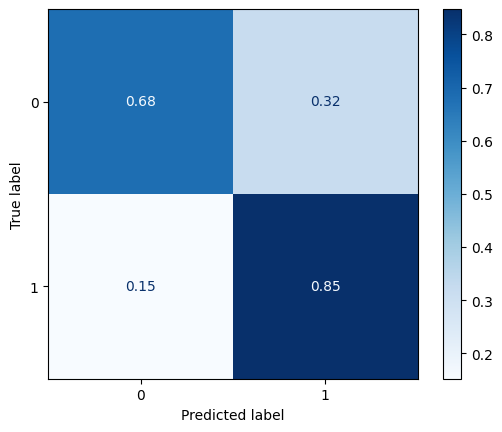

In [107]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

clf = MLPClassifier(hidden_layer_sizes=(11,11,11),
                    activation='relu')
result = cross_validate(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10,
                        scoring=['accuracy', 'precision', 'recall', 'f1'],
                        return_estimator=True)

# Predições da validação-cruzada
predictions = cross_val_predict(estimator=clf,
                        X= x_use,
                        y= y_use,
                        cv = 10)
print(predictions)
# Get test accuracy score
accuracy = result['test_accuracy'].mean()
f1_score = result['test_f1'].mean()
print("Acurracy MLP from sk-learn: {:.2f}%".format(accuracy*100))
print("F1 Score MLP from sk-learn: {:.2f}%".format(f1_score*100))

# Get test confusion matrix 
confusion_matrix = confusion_matrix(y_use, predictions, normalize='true')
ConfusionMatrixDisplay(confusion_matrix = confusion_matrix).plot(cmap='Blues')
plt.show()

acuracia_crossval['MLP'] = accuracy
f1_crossval['MLP'] = f1_score

### Comparação final dos classificadores

In [108]:
tree_metrics_holdout = pd.Series({'Classificador': 'DecisionTree', 'accuracy': acuracia_holdout['DecisionTree'], 'f1_score': f1_holdout['DecisionTree']})
knn_metrics_holdout = pd.Series({'Classificador': 'KNN', 'accuracy': acuracia_holdout['KNN'], 'f1_score': f1_holdout['KNN']})
svm_metrics_holdout = pd.Series({'Classificador': 'SVM', 'accuracy': acuracia_holdout['SVM'], 'f1_score': f1_holdout['SVM']})
mlp_metrics_holdout = pd.Series({'Classificador': 'MLP', 'accuracy': acuracia_holdout['MLP'], 'f1_score': f1_holdout['MLP']})

tree_metrics_cross_val = pd.Series({'Classificador': 'DecisionTree', 'accuracy': acuracia_crossval['DecisionTree'], 'f1_score': f1_crossval['DecisionTree']})
knn_metrics_cross_val = pd.Series({'Classificador': 'KNN', 'accuracy': acuracia_crossval['KNN'], 'f1_score': f1_crossval['KNN']})
svm_metrics_cross_val = pd.Series({'Classificador': 'SVM', 'accuracy': acuracia_crossval['SVM'], 'f1_score': f1_crossval['SVM']})
mlp_metrics_cross_val = pd.Series({'Classificador': 'MLP', 'accuracy': acuracia_crossval['MLP'], 'f1_score': f1_crossval['MLP']})

df_metrics_holdout = pd.DataFrame([tree_metrics_holdout, knn_metrics_holdout, svm_metrics_holdout, mlp_metrics_holdout])
df_metrics_cross_val = pd.DataFrame([tree_metrics_cross_val, knn_metrics_cross_val, svm_metrics_cross_val, mlp_metrics_cross_val])

print('\nHOLDOUT\n', df_metrics_holdout.head())
print('\nCROSS-VALIDATION\n', df_metrics_cross_val.head())


HOLDOUT
   Classificador  accuracy  f1_score
0  DecisionTree  0.779904  0.825758
1           KNN  0.779904  0.811475
2           SVM  0.751196  0.767857
3           MLP  0.784689  0.794521

CROSS-VALIDATION
   Classificador  accuracy  f1_score
0  DecisionTree  0.760393  0.805845
1           KNN  0.774576  0.773910
2           SVM  0.727184  0.755836
3           MLP  0.771718  0.791510
